---
title:  "CatBoost Practice 01"  
excerpt: "CatBoost, Ensemble, Gradient Descent"  

categories:  
  - Machine-Learning  
tags:  
  - Stacking  
  - Ensemble  
  - Medium  
  - Kaggle
last_modified_at: 2020-06-14T15:00:00-05:00
---

## Reference  
- [Medium Daniel Chepenko](https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14)
- 상기 Blog 역자의 Collab 코드
>  Kaggle competition 에 있는 data를 활용한다. 
>> 보험회사에 공개한, 심각한 회사차원의 보험손실 여부를 추정한 regression 모델

In [1]:
import pandas as pd

df_train = pd.read_csv('../dataset/allstate-claims-severity/train.csv')
df_test = pd.read_csv('../dataset/allstate-claims-severity/test.csv')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [3]:
print(df_train.shape) ## loss 값 있고,
print(df_test.shape)  ## loss 값 없음.

(188318, 132)
(125546, 131)


In [4]:
df_train.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]

In [5]:
df_test.head(2)

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont5     cont6  \
0   4    A    B    A    A    A    A    A    A    B  ...  0.281143  0.466591   
1   6    A    B    A    B    A    A    A    A    B  ...  0.836443  0.482425   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13    cont14  
0  0.317681  0.61229  0.34365  0.38016  0.377724  0.369858  0.704052  0.392562  
1  0.443760  0.71330  0.51890  0.60401  0.689039  0.675759  0.453468  0.208045  

[2 rows x 131 columns]

In [6]:
print("Number of missing values in train",df_train.isnull().sum().sum())
print("Number of missing values in test",df_test.isnull().sum().sum())

Number of missing values in train 0
Number of missing values in test 0


* 한꺼번에 전처리 하기 위해 묶은다음에 수행한다.

In [7]:
df_train_idx = df_train.index
df_test_idx = df_test.index
df_train['isTrain'] = True
df_test['isTrain'] = False
traintest = pd.concat([df_train, df_test], axis = 0)

In [8]:
set(df_train.columns)-set(df_test.columns)

{'loss'}

In [9]:
print(traintest.shape) ## 왜 133 이 되었지? -> isTrain 컬럼이 추가됨

(313864, 133)


* 컬럼이름 정리

In [10]:
import re
cat_pattern = re.compile("^cat([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")
cont_pattern = re.compile("^cont([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")

## cat이 들어간 컬럼. catogory 컬럼을 고르고, 뒤 3자리 숫자에 대해서, sorting
cat_col = sorted([cat for cat in traintest.columns if 'cat' in cat], key = lambda s: int(s[3:]))
## 정규식 패턴에 매칭되는 (위에서 구한 cat_col)들의 index 나열
cat_index = [i for i in range(0,len(traintest.columns)-1) if cat_pattern.match(traintest.columns[i])]

cont_col = sorted([cont for cont in traintest.columns if 'cont' in cont], key = lambda s: int(s[4:]))
cont_index = [i for i in range(0,len(traintest.columns)-1) if cont_pattern.match(traintest.columns[i])]
features = cat_col + cont_col

In [11]:
print(len(features)) ## 3개가 줄음 : isTrain,loss,id 컬럼
feats_counts = traintest[cat_col].nunique(dropna = False)

130


## 1-1. EDA columns check

[datafram.nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html)

In [12]:
len(cat_col),len(cont_col)

(116, 14)

In [13]:
feats_counts.sort_values() ## 대략 categorical 컬럼의 cardinality 를 확인하기 위해 자주 사용한다.

cat1        2
cat52       2
cat51       2
cat50       2
cat49       2
         ... 
cat112     51
cat113     63
cat109     85
cat110    134
cat116    349
Length: 116, dtype: int64

In [14]:
## .nunique : return pandas.core.series.Series / 각컬럼값들의 unique한 갯수를 확인할 수 있음.
nunique = df_train[cat_col].nunique(dropna = False)

In [15]:
print(len(nunique))
nunique[100:110]

116


cat101     19
cat102      9
cat103     13
cat104     17
cat105     20
cat106     17
cat107     20
cat108     11
cat109     84
cat110    131
dtype: int64

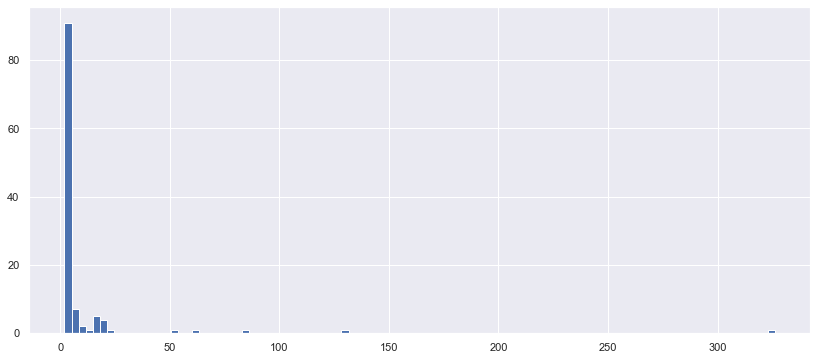

In [16]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique, bins=100)

대부분의 cardinality가 10 개 이하의, 2개 짜리의 컬럼이 매우 많고. cardinality 300 이 넘는 것도 있다.

In [17]:
mask = (nunique > 100) ## cardinality 100 개 넘는 column 들만, 따로 dataframe 으로 빼서 확인하기
df_train[cat_col].loc[:, mask] 
## cat110,cat116 컬럼의 cardinality가 100 이 넘음

cat110 cat116
0          BC     LB
1          CQ     DP
2          DK     GK
3          CS     DJ
4           C     CK
...       ...    ...
188313     EG     CK
188314     BT     DF
188315     DM     DJ
188316     AI     MD
188317     EG     MJ

[188318 rows x 2 columns]

In [18]:
df_train.cat110.value_counts()

CL    25305
EG    24654
CS    24592
EB    21396
CO    17495
      ...  
DV        1
BK        1
S         1
BI        1
BM        1
Name: cat110, Length: 131, dtype: int64

상기 같이 cardinality 높은 컬럼들은 뉴메릭으로 변환하거나, zero variance groups 으로 이니 제거하는게 나을 수 있다.

In [19]:
df_train.id.is_unique

True

In [20]:
## cat110 컬럼에 대해 각 분류값별로, 얼마나 row 가 있는지 확인함 = df_train.cat110.value_counts()
## df_train.groupby('cat110')['id'].size().sort_values() 과 동일
cat110_nunique = df_train.groupby('cat110')['id'].nunique().sort_values(ascending=False) 

In [21]:
cat110_nunique

cat110
CL    25305
EG    24654
CS    24592
EB    21396
CO    17495
      ...  
DV        1
BD        1
BI        1
EH        1
BK        1
Name: id, Length: 131, dtype: int64

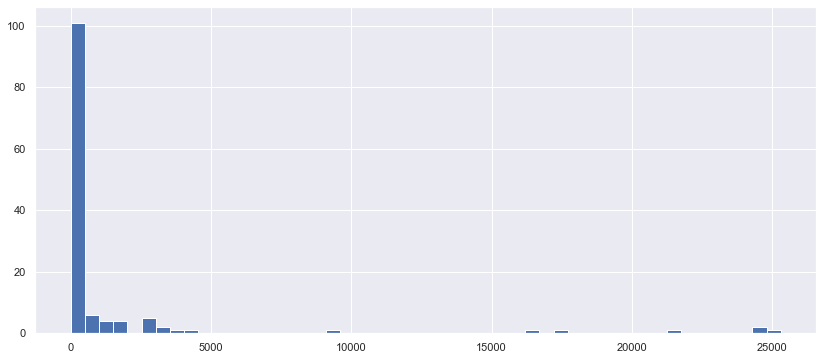

In [22]:
plt.figure(figsize=(14,6))
_ = plt.hist(cat110_nunique, bins=50)

대부분 1~2개씩 있는 것으로 보인다.

In [23]:
cat116_nunique = df_train.groupby('cat116')['id'].nunique().sort_values()

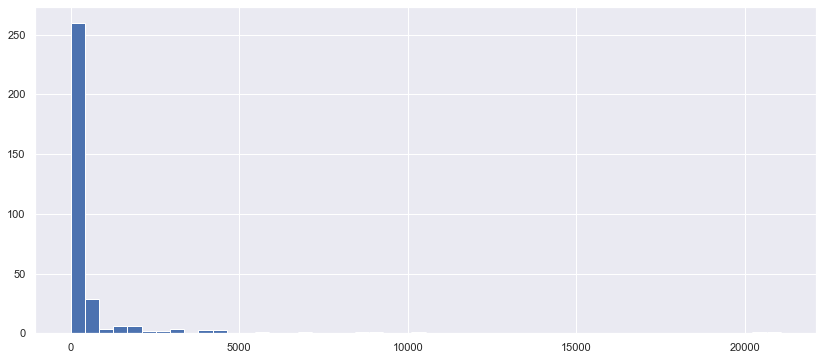

In [24]:
plt.figure(figsize=(14,6))
_ = plt.hist(cat116_nunique, bins=50)

The values are not float, they are integer, so these features are likely to be even counts. Let's look at another pack of features.  
**값은 부동하지 않고 정수이므로 이러한 특성은 짝수 카운트일 가능성이 높다. 다른 특징들을 살펴봅시다.**  

In [25]:
from tqdm.notebook import tqdm

In [26]:
df_train[cat_col].head()

cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ... cat107 cat108  \
0    A    B    A    B    A    A    A    A    B     A  ...      J      G   
1    A    B    A    A    A    A    A    A    B     B  ...      K      K   
2    A    B    A    A    B    A    A    A    B     B  ...      F      A   
3    B    B    A    B    A    A    A    A    B     A  ...      K      K   
4    A    B    A    B    A    A    A    A    B     B  ...      G      B   

  cat109 cat110 cat111 cat112 cat113 cat114 cat115 cat116  
0     BU     BC      C     AS      S      A      O     LB  
1     BI     CQ      A     AV     BM      A      O     DP  
2     AB     DK      A      C     AF      A      I     GK  
3     BI     CS      C      N     AE      A      O     DJ  
4      H      C      C      Y     BM      A      K     CK  

[5 rows x 116 columns]

In [27]:
df_train.cat1.unique().tolist()

['A', 'B']

In [28]:
df_train['cat112'].loc[df_train['cat112'].isin(df_train.cat1.unique().tolist())]

17        A
34        A
77        A
107       A
292       B
         ..
187955    A
188037    A
188266    A
188281    A
188303    B
Name: cat112, Length: 2834, dtype: object

In [29]:
## 예시
print(len(set(traintest['cat116'].factorize()[0])))

349


In [30]:
#Encoding categorical features to find duplicates
train_enc =  pd.DataFrame(index = traintest.index)

## categorical = cat_col 에 대해서, 모두 숫자화로 변형시킨다. traintest = train+test concat
for col in tqdm(traintest[cat_col].columns): 
    train_enc[col] = traintest[col].factorize()[0]

In [31]:
train_enc.head(3)

cat1  cat2  cat3  cat4  cat5  cat6  cat7  cat8  cat9  cat10  ...  cat107  \
0     0     0     0     0     0     0     0     0     0      0  ...       0   
1     0     0     0     1     0     0     0     0     0      1  ...       1   
2     0     0     0     1     1     0     0     0     0      1  ...       2   

   cat108  cat109  cat110  cat111  cat112  cat113  cat114  cat115  cat116  
0       0       0       0       0       0       0       0       0       0  
1       1       1       1       1       1       1       0       0       1  
2       2       2       2       1       2       2       0       1       2  

[3 rows x 116 columns]

In [32]:
dup_cols = {} ## 중복되는 컬럼을 제거하는 과정
import numpy as np

for i, c1 in enumerate(tqdm(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]: ## i번째 컬럼이후 다른 모든 컬럼
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]): ## 바로 next 컬럼이, 지금 컬럼과 통으로 일치하면~
            dup_cols[c2] = c1

In [33]:
## 다행히 중복되는 컬럼은 없다.
dup_cols

{}

여기서, cat_col 에 대해 보면,, 모든 값이 알파벳의 조합으로만 되어있다. 따라서,  
Factorize 하면, 결국 같은 value 들은 같은 숫자를 가지게 된다.  
<span style='color:red'>원작자는 이를 통해, 각 cat_columns 값이 같은면 1, 아니면 0으로 하여 평균값을 구하였고  
이를 통해 컬럼들의 유사성을 파악했다.</span>

In [34]:
test_list = ['a','b','c','d','e']

In [35]:
alst = []
for i,c1 in enumerate(test_list):
    blst = [] 
    for j,c2 in enumerate(test_list):
        if i>=j: ##
            blst.append(c1+c2)            
#             blst.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
        else: ## i < j 인 경우
            blst.append(c2+c1)
#             blst.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())
    alst.append(blst)

In [36]:
alst

[['aa', 'ba', 'ca', 'da', 'ea'],
 ['ba', 'bb', 'cb', 'db', 'eb'],
 ['ca', 'cb', 'cc', 'dc', 'ec'],
 ['da', 'db', 'dc', 'dd', 'ed'],
 ['ea', 'eb', 'ec', 'ed', 'ee']]

## 1-2. EDA 컬럼별 연관성 분석

cat_col들의 연관성 보는 함수 (위의 설명 참조)

In [37]:
def autolabel(arrayA):
    ''' label each colored square with the corresponding data value. 
    If value > 20, the text is in black, else in white.
    '''
    arrayA = np.array(arrayA)
    for i in range(arrayA.shape[0]):
        for j in range(arrayA.shape[1]):
                plt.text(j,i, "%.2f"%arrayA[i,j], ha='center', va='bottom',color='w')


def gt_matrix(train, feats,sz=18): ## feats 컬럼명
    a = []
    for i,c1 in enumerate(feats):
        b = [] 
        for j,c2 in enumerate(feats):
            mask = (~train[c1].isnull()) & (~train[c2].isnull()) ## c1,c2 컬럼 둘다 null 아닌 row 만 표시
            if i>=j: ##
                b.append((train.loc[mask,c1].values>=train.loc[mask,c2].values).mean())
            else: ## i < j 인 경우
                b.append((train.loc[mask,c1].values>train.loc[mask,c2].values).mean())
        a.append(b)
    plt.figure(figsize = (sz,sz))
    plt.imshow(a, interpolation = 'None')
    _ = plt.xticks(range(len(feats)),feats,rotation = 90)
    _ = plt.yticks(range(len(feats)),feats,rotation = 0)
    autolabel(a)

In [38]:
mask = (~train_enc['cat3'].isnull()) & (~train_enc['cat1'].isnull()) 
train_enc.loc[mask,'cat3'].values 

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [39]:
## 세로영역
print(train_enc.loc[mask,'cat2'].values >= train_enc.loc[mask,'cat1'].values)
print((train_enc.loc[mask,'cat2'].values >= train_enc.loc[mask,'cat1'].values).mean())

[ True  True  True ... False  True  True]
0.9280388958274922


In [40]:
## 가로 영역
print(train_enc.loc[mask,'cat1'].values > train_enc.loc[mask,'cat3'].values)
print((train_enc.loc[mask,'cat1'].values > train_enc.loc[mask,'cat3'].values).mean())

[False False False ...  True False False]
0.24539609512400276


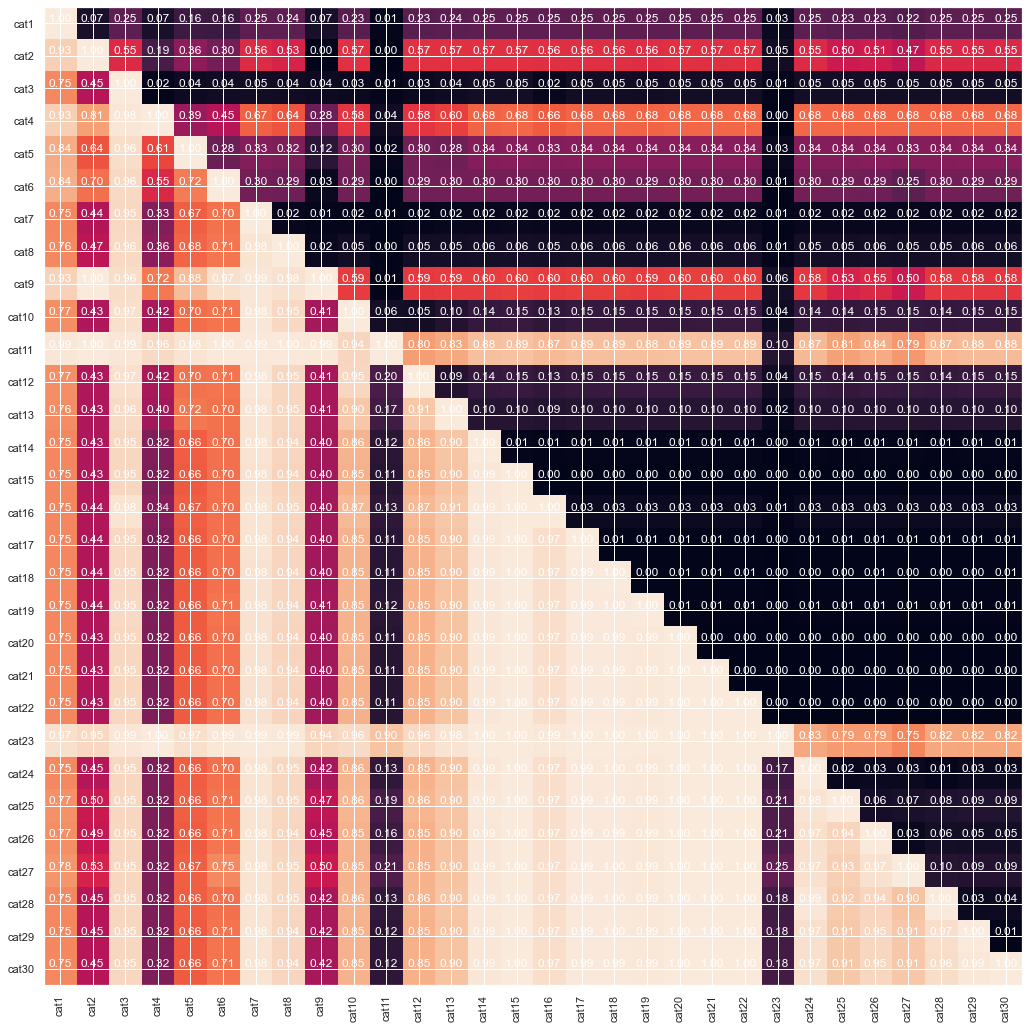

In [41]:
#from cat13 to cat30
gt_matrix(train_enc, cat_col[:30])

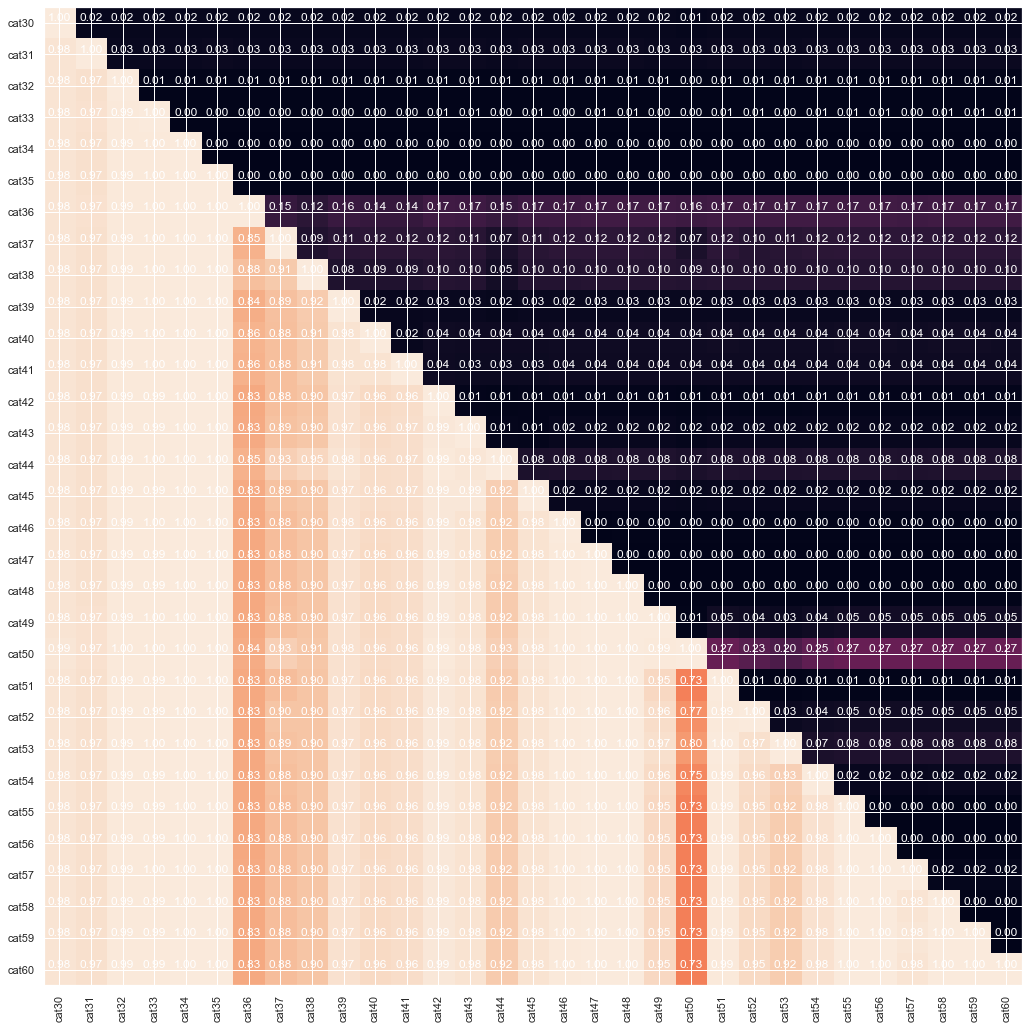

In [42]:
#everything except cat36, cat 37, cat50
gt_matrix(train_enc, cat_col[29:60])

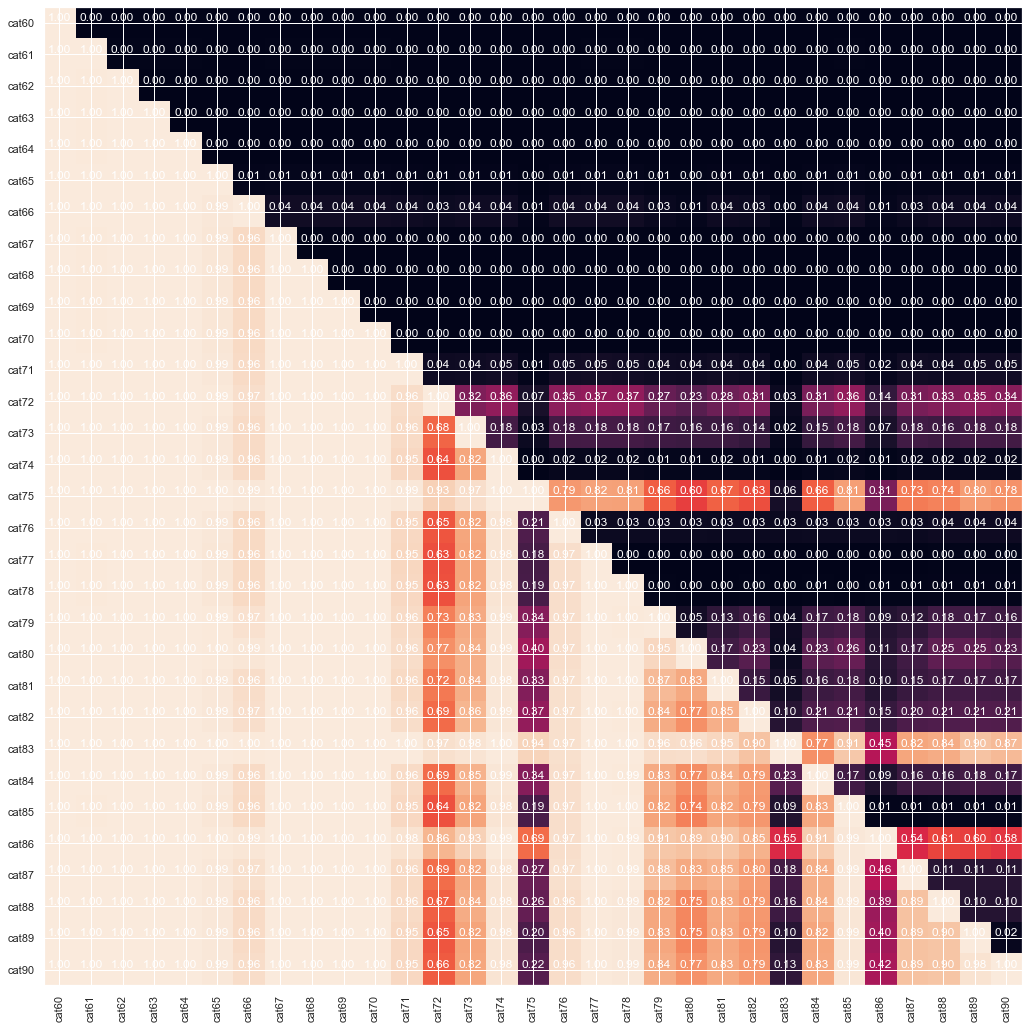

In [43]:
#from cat60 to cat71, cat74, from cat76 to cat78
gt_matrix(train_enc, cat_col[59:90])

In [44]:
cum_cat_1 = []
for i in range(12,23):
    cum_cat_1.append('cat'+str(i))

cum_cat_2 = []
for i in range(24,50):
    cum_cat_2.append('cat'+str(i))

cum_cat_3 = []
for i in range(51,72):
    cum_cat_3.append('cat'+str(i)) 

From the graph above we can see that some of the features are cummulative, as in some cases the one is strictly greater than the other.
 Finally lets look at correlation between continious features. Probably dimension reduction techniques can help us

## 1-3. EDA -Numeric 변수들 상관계수 확인하기

In [45]:
threshold = 0.5
data_corr = traintest[cont_col].corr()
# List of pairs along with correlation above threshold
corr_list = []

#Search for the highly correlated pairs
for i in range(0,len(cont_col)): #for 'size' features
    for j in range(i+1,len(cont_col)): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) #store correlation and columns index

#Sort to show higher ones first            
s_corr_list = sorted(corr_list,key=lambda x: abs(x[0]),reverse=True)

#Print correlations and column names
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cont_col[i],cont_col[j],v))

cont11 and cont12 = 0.99
cont1 and cont9 = 0.93
cont6 and cont10 = 0.88
cont6 and cont13 = 0.81
cont1 and cont10 = 0.81
cont6 and cont9 = 0.80
cont6 and cont12 = 0.79
cont9 and cont10 = 0.79
cont6 and cont11 = 0.77
cont1 and cont6 = 0.76
cont7 and cont11 = 0.75
cont7 and cont12 = 0.74
cont10 and cont12 = 0.72
cont10 and cont13 = 0.71
cont10 and cont11 = 0.70
cont6 and cont7 = 0.66
cont9 and cont13 = 0.64
cont9 and cont12 = 0.63
cont1 and cont12 = 0.61
cont9 and cont11 = 0.61
cont1 and cont11 = 0.60
cont1 and cont13 = 0.53
cont4 and cont8 = 0.53


## 1-4. EDA - PCA dimension reduction

In [147]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [148]:
traintest.shape[0] == len(df_train_idx.to_list())+len(df_test_idx.to_list())

True

If 0 < n_components < 1 and svd_solver == 'full'  
> select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.  
> diag 고유값행렬 (eigen value (lambda)) 의  0.95(95%)에 해당하는 변수들을 모두 본다는 의미임  
> 만약 0.95 -> 0.7 -> 0.5 로 될 수록, 백분위수 컨셉으로 총량의 variance 가 작아지니, len(pca.explained_variance_) 이 작아진다.

In [149]:
## numeric 변수들로만 시행
scaler = StandardScaler()
traintest_scaled = scaler.fit_transform(traintest[cont_col]) ## modify scale in numeric columns

In [150]:
print(traintest_scaled.shape)

(313864, 14)


In [151]:
pca = PCA(n_components=0.95, svd_solver='full').fit(traintest_scaled)
traintest_pca = pca.transform(traintest_scaled)

In [152]:
print(len(pca.explained_variance_)),print(pca.explained_variance_)

9
[6.15481809 2.00696816 1.49785047 0.99611156 0.88174836 0.75109768
 0.56965726 0.39493657 0.30094088]


(None, None)

In [153]:
traintest_pca_df = pd.DataFrame(data = traintest_pca)
traintest_pca_df['id'] = traintest['id'].values

In [154]:
print(traintest[cont_col].shape)

(313864, 14)


In [155]:
np.dot(traintest_scaled,pca.components_.T)[0]

array([ 2.70453183, -2.10166972, -1.51128802,  0.61746921, -0.54985965,
       -0.21919071,  0.94667346,  1.10674658, -1.36947719])

In [156]:
print(traintest_pca_df.shape)
traintest_pca_df.head()

(313864, 10)


0         1         2         3         4         5         6  \
0  2.704532 -2.101670 -1.511288  0.617469 -0.549860 -0.219191  0.946673   
1 -1.132381 -0.395118  2.283496 -0.762693 -0.352918 -0.593252 -1.064844   
2 -2.948887  0.339230 -1.375522  1.256290 -0.212120  0.107400  0.040797   
3 -1.597690  0.072182 -0.424028  0.392106 -0.004357 -1.252742 -0.050669   
4 -4.068934 -1.052458 -0.660599 -0.245261 -0.841898  0.906329 -0.748438   

          7         8  id  
0  1.106747 -1.369477   1  
1  0.443155  0.220732   2  
2  0.128152 -0.309722   5  
3  0.638594 -0.293227  10  
4  0.017867 -0.517443  11

In [157]:
traintest[cont_col].describe()

cont1          cont2          cont3          cont4  \
count  313864.000000  313864.000000  313864.000000  313864.000000   
mean        0.494096       0.507089       0.498653       0.492021   
std         0.187768       0.207056       0.201961       0.211101   
min         0.000016       0.001149       0.002634       0.176921   
25%         0.347403       0.358319       0.336963       0.327354   
50%         0.475784       0.555782       0.527991       0.452887   
75%         0.625272       0.681761       0.634224       0.652072   
max         0.984975       0.862654       0.944251       0.956046   

               cont5          cont6          cont7          cont8  \
count  313864.000000  313864.000000  313864.000000  313864.000000   
mean        0.487513       0.491442       0.485360       0.486823   
std         0.209063       0.205394       0.178531       0.199442   
min         0.281143       0.012683       0.069503       0.236880   
25%         0.281143       0.336105       0.351299       0.317960   
50%         0.422268       0.440945       0.438650       0.441060   
75%         0.643315       0.655818       0.591165       0.623580   
max         0.983674       0.997162       1.000000       0.982800   

              cont9         cont10         cont11         cont12  \
count  313864.00000  313864.000000  313864.000000  313864.000000   
mean        0.48571       0.498403       0.493850       0.493503   
std         0.18185       0.185906       0.210002       0.209716   
min         0.00008       0.000000       0.035321       0.036232   
25%         0.35897       0.364580       0.310961       0.314945   
50%         0.44145       0.461190       0.457203       0.462286   
75%         0.56889       0.619840       0.678924       0.679096   
max         0.99540       0.994980       0.998742       0.998484   

              cont13         cont14  
count  313864.000000  313864.000000  
mean        0.493917       0.495665  
std         0.212911       0.222537  
min         0.000228       0.178568  
25%         0.315758       0.294657  
50%         0.363547       0.407020  
75%         0.689974       0.724707  
max         0.988494       0.844848

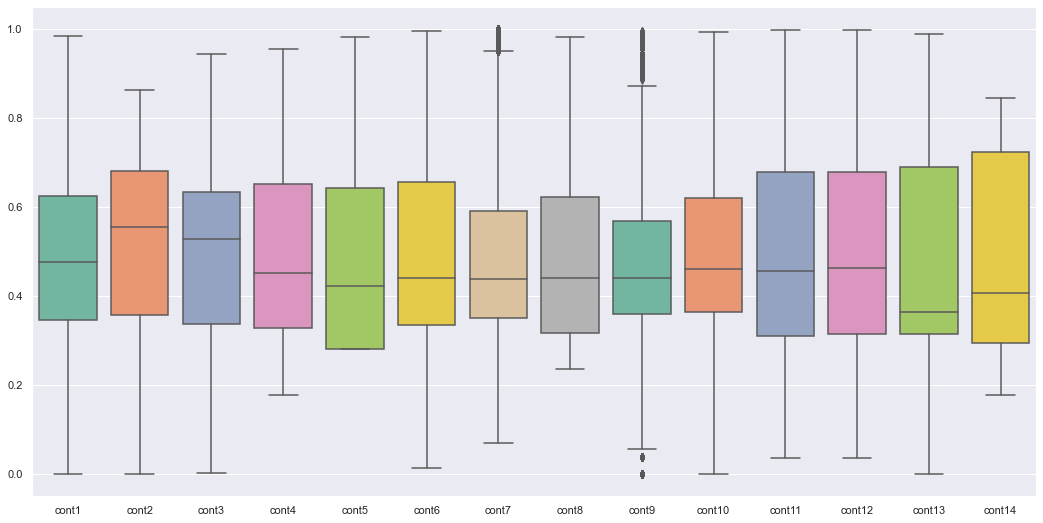

In [158]:
plt.figure(figsize=(18,9))
ax = sns.boxplot(data=traintest[cont_col], orient="v", palette="Set2")

## 1-5. EDA - 데이터 왜도(skewness) 확인

For **normally distributed data, the skewness should be about zero.** For unimodal continuous distributions, a skewness value greater than zero means that there is more weight in the right tail of the distribution. The function skewtest can be used to determine if the skewness value is close enough to zero, statistically speaking.

In [159]:
from scipy.stats import skew ## Compute the sample skewness of a data set.

skewed_cols = []
for col in cont_col:
    if skew(traintest[col]) > 0.75:
        skewed_cols.append(col)

In [160]:
## 왜도가 0.75 넘는 컬럼 찾아내기
skewed_cols

['cont7', 'cont9']

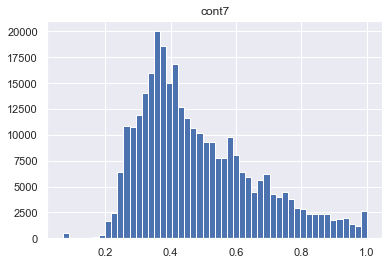

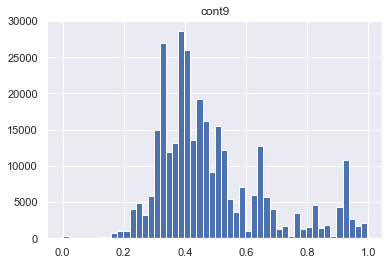

In [161]:
for col in skewed_cols:
    plt.figure()
    plt.title(col)
    plt.hist(traintest[col], bins = 50)

As we see the features cont7 and cont 9 are left skewed. So we need to apply transformation. BoxCox could be a good way to deal with this problem

In [162]:
from scipy import stats
stats.boxcox(traintest[col])[0] ## unnormal distribution data -> normal distribution data  (일종의 Skill)

array([-0.37071516, -0.86886216, -1.06116485, ..., -0.05663025,
       -0.92868009, -0.94375053])

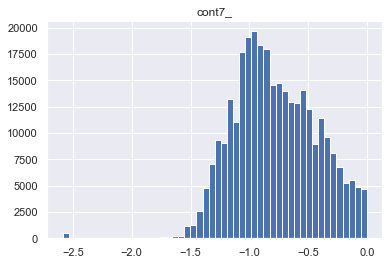

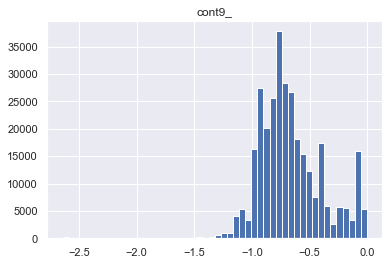

In [163]:
for col in skewed_cols:
    col_name = col+"_"
    traintest[col_name] = stats.boxcox(traintest[col])[0]
    plt.figure()
    plt.title(col_name)
    plt.hist(traintest[col_name], bins = 50)

## 1-6. EDA - Y 컬럼(=loss) 컬럼의 밀도를 보고, left skewness 인것에 대해 log 변환한다.

Text(0.5, 1.0, 'NO-LOG-LOSS column')

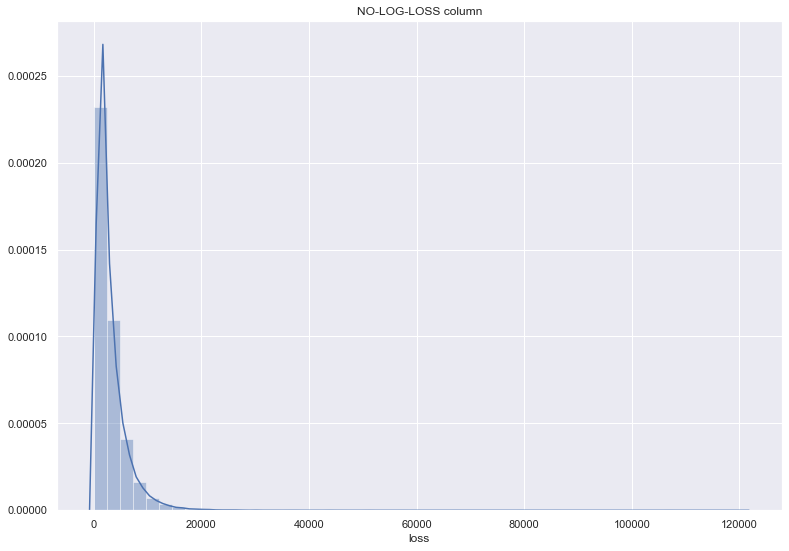

In [164]:
## log 를 씌워서, loss 컬럼의 밀도 살펴보기
plt.figure(figsize=(13,9))
ax = sns.distplot(df_train["loss"])
ax.set_title('NO-LOG-LOSS column')

Text(0.5, 1.0, 'LOG-LOSS column')

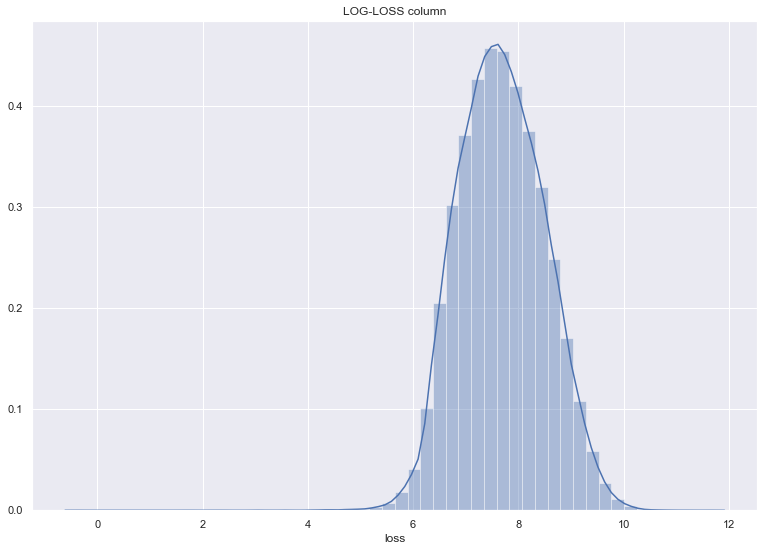

In [165]:
## log 를 씌워서, loss 컬럼의 밀도 살펴보기
plt.figure(figsize=(13,9))
sns.distplot(np.log(df_train["loss"])).set_title('LOG-LOSS column')

## 2-1. Modeling Without tunning, apply Catboost - Base
- y 에 대해서는 np.log(y) 로 변형시켜서 사용했다.  
- Firslty try to run model without any EDA transformation

In [166]:
from catboost import CatBoostRegressor

In [167]:
df_train.head(2)

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont7    cont8  \
0   1    A    B    A    B    A    A    A    A    B  ...  0.335060  0.30260   
1   2    A    B    A    A    A    A    A    A    B  ...  0.436585  0.60087   

     cont9   cont10    cont11    cont12    cont13    cont14     loss isTrain  
0  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18    True  
1  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60    True  

[2 rows x 133 columns]

In [168]:
df_train.isTrain.value_counts()

True    188318
Name: isTrain, dtype: int64

In [169]:
## features : loss,isTrain 컬럼을 제외한 순수 Feature 컬럼
X = df_train.drop('id', axis = 1)[features]
y = np.log(df_train['loss'])

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

In [170]:
## cat이 들어간 컬럼. catogory 컬럼을 고르고, 뒤 3자리 숫자에 대해서, sorting
cat_col = sorted([cat for cat in X_train.columns if 'cat' in cat], key = lambda s: int(s[3:]))
## 정규식 패턴에 매칭되는 (위에서 구한 cat_col)들의 index 나열
cat_index = [i for i in range(0,len(X_train.columns)-1) if cat_pattern.match(X_train.columns[i])]

cont_col = sorted([cont for cont in X_train.columns if 'cont' in cont], key = lambda s: int(s[4:]))
cont_index = [i for i in range(0,len(X_train.columns)-1) if cont_pattern.match(X_train.columns[i])]
features = cat_col + cont_col

In [171]:
params = {'iterations':100, 'learning_rate':0.1, 'eval_metric':"MAE"}

In [172]:
model_0 = CatBoostRegressor(**params)

In [173]:
model_0.fit(X_train, y_train, cat_index, eval_set=(X_validation, y_validation) ,plot=True,verbose=False,use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [174]:
print(model_0.evals_result_.keys())
print(model_0.learning_rate_,model_0.tree_count_)
mae_min_idx = np.argmin(model_0.evals_result_['validation']['MAE'])
print("Minimize MAE value is {:.6f} in Validation Set".format(model_0.evals_result_['validation']['MAE'][mae_min_idx]))

dict_keys(['learn', 'validation'])
0.10000000149011612 100
Minimize MAE value is 0.429066 in Validation Set


In [175]:
## y 결과값에 log 변환한 값이 나올테니, 이를 다시 원본값으로 돌리기 위해 np.exp()를 씌웠다.
df_test['loss'] = np.exp(model_0.predict(df_test[features]))

In [176]:
df_test.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont7    cont8  \
0   4    A    B    A    A    A    A    A    A    B  ...  0.317681  0.61229   
1   6    A    B    A    B    A    A    A    A    B  ...  0.443760  0.71330   
2   9    A    B    A    B    B    A    B    A    B  ...  0.325779  0.29758   
3  12    A    A    A    A    B    A    A    A    A  ...  0.342355  0.40028   
4  15    B    A    A    A    A    B    A    A    A  ...  0.391833  0.23688   

     cont9   cont10    cont11    cont12    cont13    cont14 isTrain  \
0  0.34365  0.38016  0.377724  0.369858  0.704052  0.392562   False   
1  0.51890  0.60401  0.689039  0.675759  0.453468  0.208045   False   
2  0.34365  0.30529  0.245410  0.241676  0.258586  0.297232   False   
3  0.33237  0.31480  0.348867  0.341872  0.592264  0.555955   False   
4  0.43731  0.50556  0.359572  0.352251  0.301535  0.825823   False   

          loss  
0  1647.399801  
1  2013.457326  
2  8774.000309  
3  5124.285559  
4   931.720484  

[5 rows x 133 columns]

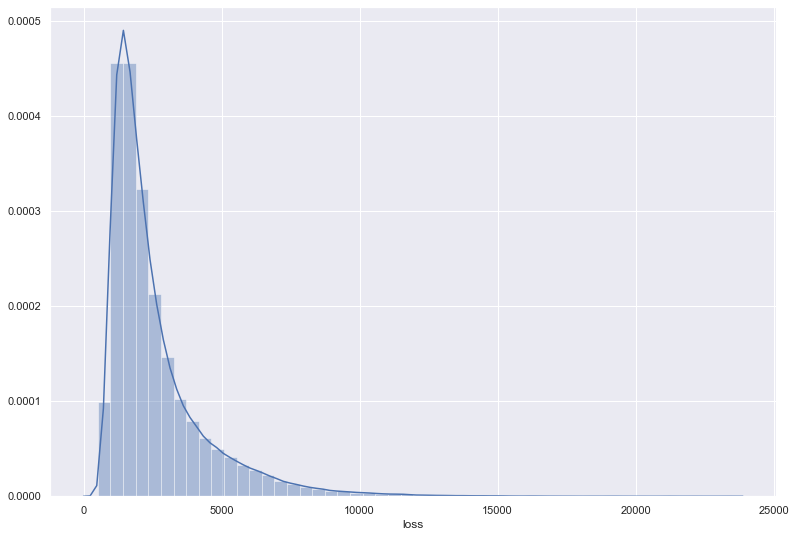

In [177]:
plt.figure(figsize=(13,9))
sns.distplot(df_test["loss"])

In [178]:
df_test.to_csv('../dataset/kaggle_submission/acs_submission_0.csv', sep = ',', columns = ['id', 'loss'], index=False)

## 2-2. Modiling With PCA, apply Catboost
 - cont_col 만 PCA decomposition 시 사용했음. 주의할 것!  
 - Try to reduce dimenstions with PCA

In [179]:
traintest_pca_df.head()

0         1         2         3         4         5         6  \
0  2.704532 -2.101670 -1.511288  0.617469 -0.549860 -0.219191  0.946673   
1 -1.132381 -0.395118  2.283496 -0.762693 -0.352918 -0.593252 -1.064844   
2 -2.948887  0.339230 -1.375522  1.256290 -0.212120  0.107400  0.040797   
3 -1.597690  0.072182 -0.424028  0.392106 -0.004357 -1.252742 -0.050669   
4 -4.068934 -1.052458 -0.660599 -0.245261 -0.841898  0.906329 -0.748438   

          7         8  id  
0  1.106747 -1.369477   1  
1  0.443155  0.220732   2  
2  0.128152 -0.309722   5  
3  0.638594 -0.293227  10  
4  0.017867 -0.517443  11

In [180]:
print("traintest_pca_df.shape :{}".format(traintest_pca_df.shape))
print("traintest.shape :{}".format(traintest.shape))

traintest_pca_df.shape :(313864, 10)
traintest.shape :(313864, 135)


df_train_idx,df_test_idx 각각에 해당하는 데이터를 골라냄 (index 를 이용해서)  
traintest_pca_df 는 이미 PCA 를 이용해서,원래의 row,columns 등 shape가 축소된 형태임

In [181]:
type(df_train_idx)

pandas.core.indexes.range.RangeIndex

In [182]:
traintest_pca_df.loc[df_train_idx,:].shape

(188318, 10)

In [183]:
# df_train_pca = traintest_pca_df[traintest_pca_df['id'].isin(df_train_idx)]
# df_test_pca = traintest_pca_df[traintest_pca_df['id'].isin(df_test_idx)]
## 원본코드가 이상해서 바꿈

df_train_pca = traintest_pca_df.loc[df_train_idx,:]
df_test_pca = traintest_pca_df.loc[df_test_idx,:]

In [184]:
len(df_train_pca)

188318

In [185]:
print("df_train.shape :{}".format(df_train.shape))
print("df_test.shape :{}".format(df_test.shape))
print()
print("df_train_pca.shape :{}".format(df_train_pca.shape))
print("df_test_pca.shape :{}".format(df_test_pca.shape))

df_train.shape :(188318, 133)
df_test.shape :(125546, 133)

df_train_pca.shape :(188318, 10)
df_test_pca.shape :(125546, 10)


<span style="color:blue"> **df_train_pca(pca 축소된 주요인 컬럼)을 id 기준으로 merge 함.</span>  
이때, cont_col 컬럼들은 제외함**(pca 가 cont_col 컬럼에 해당함으로)  

정리하면, train_set 에서, cont 컬럼(뉴메릭컬럼) 은, id 값을 맞추어서, pca 로 추려진 요인들의 값으로 대체함

In [186]:
df_train_ = df_train.drop(cont_col, axis = 1).set_index('id').join(df_train_pca.set_index('id'))
df_test_ = df_test.drop(cont_col, axis = 1).set_index('id').join(df_test_pca.set_index('id'))

In [187]:
df_train_.head(2)

cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ... isTrain         0  \
id                                                     ...                     
1     A    B    A    B    A    A    A    A    B     A  ...    True  2.704532   
2     A    B    A    A    A    A    A    A    B     B  ...    True -1.132381   

           1         2         3         4         5         6         7  \
id                                                                         
1  -2.101670 -1.511288  0.617469 -0.549860 -0.219191  0.946673  1.106747   
2  -0.395118  2.283496 -0.762693 -0.352918 -0.593252 -1.064844  0.443155   

           8  
id            
1  -1.369477  
2   0.220732  

[2 rows x 127 columns]

In [188]:
df_test_.head(2)

cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ...         loss   0  \
id                                                     ...                    
4     A    B    A    A    A    A    A    A    B     A  ...  1647.399801 NaN   
6     A    B    A    B    A    A    A    A    B     A  ...  2013.457326 NaN   

     1   2   3   4   5   6   7   8  
id                                  
4  NaN NaN NaN NaN NaN NaN NaN NaN  
6  NaN NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 127 columns]

In [189]:
print("df_train_.shape :{}".format(df_train_.shape))
print("df_test_.shape :{}".format(df_test_.shape))

df_train_.shape :(188318, 127)
df_test_.shape :(125546, 127)


In [190]:
X = df_train_.drop('loss', axis = 1)
y = np.log(df_train_['loss'])

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8)

In [191]:
model_1 = CatBoostRegressor(**params)
model_1.fit(X_train, y_train, cat_index, eval_set=(X_validation, y_validation) ,plot=True,verbose=False,use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [192]:
print(model_1.evals_result_.keys())
print(model_1.learning_rate_,model_1.tree_count_)
mae_min_idx = np.argmin(model_1.evals_result_['validation']['MAE'])
print("Minimize MAE value is {:.6f} in Validation Set".format(model_1.evals_result_['validation']['MAE'][mae_min_idx]))

dict_keys(['learn', 'validation'])
0.10000000149011612 100
Minimize MAE value is 0.433949 in Validation Set


In [193]:
## y 결과값에 log 변환한 값이 나올테니, 이를 다시 원본값으로 돌리기 위해 np.exp()를 씌웠다.
df_test_['loss'] = np.exp(model_1.predict(df_test_.drop('loss', axis=1)))

In [194]:
df_test_.to_csv('../dataset/kaggle_submission/acs_submission_1.csv', sep = ',', columns = ['loss'], index=False)

## PCA를 활용한 model_1 을 tunning 하면,

In [195]:
# model_1.fit(X_train, y_train, cat_index, eval_set=(X_validation, y_validation) ,plot=True,verbose=False,use_best_model=True)

In [196]:
model_1_tuned = CatBoostRegressor(iterations=1500, learning_rate=0.01, depth =8, task_type = "GPU", eval_metric = "MAE", l2_leaf_reg=3, bagging_temperature=1,one_hot_max_size=0)
model_1_tuned.fit(X_train, y_train, cat_index, eval_set=(X_validation, y_validation) ,plot=True,verbose=False,use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

확실히 더 좋은 성능을 보여준다.

In [142]:
print(model_1_tuned.evals_result_.keys())
print(model_1_tuned.learning_rate_,model_1_tuned.tree_count_)
mae_min_idx = np.argmin(model_1_tuned.evals_result_['validation']['MAE'])
print("Minimize MAE value is {:.6f} in Validation Set".format(model_1_tuned.evals_result_['validation']['MAE'][mae_min_idx]))

dict_keys([])
None None


KeyError: 'validation'